In [133]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns # data visualization package
from dataclasses import dataclass
import warnings
from IPython.core.display import display
sns.set()
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [134]:
path = 'hedge_fund_replication_data.xlsx'
pd_hedge_rep = pd.read_excel(path, sheet_name = 'HEDGE-REP', index_col='date')
pd_merrill_facs = pd.read_excel(path, sheet_name = 'MERRILL-FACS', index_col='date')
pd_multi_asset = pd.read_excel(path, sheet_name = 'MULTI-ASSET', index_col='date')

In [135]:
@dataclass
# To use dataclass as the decorator, avoid using __init__() to initialize
# instead, claim the variables and their types as in C++
# This is an empty class so far with only several variables, no method inside
class RegressionsOutput:
    excess_ret_stats: pd.DataFrame
    params: pd.DataFrame
    residuals: pd.DataFrame
    tstats: pd.DataFrame
    other: pd.DataFrame
    df: pd.DataFrame

# This is the regression functions of any given data-set
def lfm_time_series_regression(df, portfolio_names, factors, annualize_factor=12):
    # will select all factors as the rows
    # excess_ret_stats is a dataframe with index of factors(passed in) and two rows called average and std
    excess_ret_stats = pd.DataFrame(index=factors, columns=['average', 'std'], dtype=float)
    for factor in factors:
        excess_ret_stats.loc[factor, 'average'] = annualize_factor * df[factor].mean() # Every factor to compute its mean value
        excess_ret_stats.loc[factor, 'std'] = np.sqrt(annualize_factor) * df[factor].std() # Every factor to compute its std
        excess_ret_stats.loc[factor, 'sharpe_ratio'] = \
            excess_ret_stats.loc[factor, 'average'] / excess_ret_stats.loc[factor, 'std'] # Every factor to compute its sharpe ratio
        # Here I'll just report the unscaled skewness
        excess_ret_stats.loc[factor, 'skewness'] = df[factor].skew()
        # excess_ret_stats.loc[factor, 'skewness'] = annualize_factor * df[factor].skew()

    _temp_excess_ret_stats = excess_ret_stats.copy()
    _temp_excess_ret_stats.loc['const', :] = 0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rhs = sm.add_constant(df[factors])
    # four DataFrames with portfolio names as their columns ready
    # portfolio names are passed in as arguments in the function execess_ret_stats()
    df_params = pd.DataFrame(columns=portfolio_names)
    df_other = pd.DataFrame(columns=portfolio_names)
    df_residuals = pd.DataFrame(columns=portfolio_names)
    df_tstats = pd.DataFrame(columns=portfolio_names)
    # for each portfolio
    for portfolio in portfolio_names:
        lhs = df[portfolio]

        res = sm.OLS(lhs, rhs, missing='drop').fit() # to fit the portfolio against the factors
        # this will output res, a class with many variables such as params, rsquared, resid, and tvalues

        df_params[portfolio] = res.params # for each portfolio, fill in their betas, params are the betas
        df_params.loc['const', portfolio] = annualize_factor * res.params['const']
        df_other.loc['r_squared', portfolio] = res.rsquared
        df_other.loc['model_implied_excess_ret', portfolio] = df_params[portfolio] @ _temp_excess_ret_stats['average']
        df_other.loc['ave_excess_ret', portfolio] = \
            annualize_factor * df[portfolio].mean() # the ave_excess_ret is already a mean value
        df_other.loc['std_excess_ret', portfolio] = \
            np.sqrt(annualize_factor) * df[portfolio].std()
        df_other.loc['skewness_excess_ret', portfolio] = \
            annualize_factor * df[portfolio].skew()
        df_other.loc['sharpe_ratio', portfolio] = \
            df_other.loc['ave_excess_ret', portfolio] / df_other.loc['std_excess_ret', portfolio]
        df_residuals[portfolio] = res.resid
        df_tstats[portfolio] = res.tvalues

        # use the parameters obtained from the function to build a RegressionOutput class
        regression_outputs = RegressionsOutput(
        excess_ret_stats.T,
        df_params.T,
        df_residuals,
        df_tstats.T,
        df_other.T,
        df)

    return regression_outputs

### Problem 1:
For every asset in the "HEDGE-REP" tab, calculate the excess returns by subtracting the
USGG3M Index in each period.

Based on the excess returns, report the following summary statistics:
* mean
* volatility
* Sharpe ratio
* Market Beta, (based on SPY).
* Treynor Ratio, (which uses the market beta calculated above.)
* Information ratio, (based on the regression ran to calculate market beta above.)

Annualize all these statistics. (Multiply means by 12, vols by sqaure root of 12, and don't multiply betas at all.)


In [136]:
# To calculate the excessive returns
# For every asset in the "HEDGE-REP" tab, calculate the excess returns by subtracting the
# USGG3M Index in each period.

# first to extract the column names to a list
portfolio_names = pd_hedge_rep.columns.values.tolist()

USGG3M = pd_merrill_facs['USGG3M Index']
# subtract 函数每一列都会减去相应的值, now we have the excessive returns for each portfolio
df_hedge_rep_excess = pd_hedge_rep.subtract(USGG3M, axis=0) # axis = 0代表按每一列不断向下的执行方法

# we're told to regress its performance based on SPY
# the output is from sm.OLS.fit(), is a dataset with multiple columns
hedge_rep_regs = lfm_time_series_regression(
    df=df_hedge_rep_excess,
    portfolio_names=portfolio_names,
    factors=['SPY US Equity'])

def create_table1(regs_object):
    table1 = pd.DataFrame(regs_object.other[['ave_excess_ret', 'std_excess_ret', 'sharpe_ratio']])
    table1['Mkt beta'] = regs_object.params['SPY US Equity']
    table1['Mkt Corr'] = regs_object.df.corr()['SPY US Equity']

    table1['Treynor_ratio'] = regs_object.other['ave_excess_ret'] / regs_object.params['SPY US Equity']
    table1['Inf_ratio'] = regs_object.params['const'] / (regs_object.residuals.std()*np.sqrt(12))

    return table1

table1 = create_table1(hedge_rep_regs)
table1.style.set_caption('The Statistics of Portfolios')
display(table1)
display(hedge_rep_regs.other)

,ave_excess_ret,std_excess_ret,sharpe_ratio,Mkt beta,Mkt Corr,Treynor_ratio,Inf_ratio
HFRIFWI Index,0.0276,0.0588,0.4688,0.3915,0.8990,0.0704,-0.8182
MLEIFCTR Index,0.0227,0.0515,0.4410,0.3555,0.9319,0.0639,-1.1480
MLEIFCTX Index,0.0210,0.0513,0.4096,0.3539,0.9315,0.0593,-1.2310
HDG US Equity,0.0121,0.0547,0.2216,0.3687,0.9111,0.0329,-1.5474
QAI US Equity,0.0176,0.0457,0.3858,0.2889,0.8524,0.0611,-0.7624
SPY US Equity,0.1242,0.1350,0.9202,1.0000,1.0000,0.1242,1.0816


,r_squared,model_implied_excess_ret,ave_excess_ret,std_excess_ret,skewness_excess_ret,sharpe_ratio
HFRIFWI Index,0.8081,0.0486,0.0276,0.0588,-19.7377,0.4688
MLEIFCTR Index,0.8683,0.0441,0.0227,0.0515,-7.0825,0.4410
MLEIFCTX Index,0.8678,0.0440,0.0210,0.0513,-6.9457,0.4096
HDG US Equity,0.8302,0.0458,0.0121,0.0547,-6.1726,0.2216
QAI US Equity,0.7266,0.0359,0.0176,0.0457,-7.9824,0.3858
SPY US Equity,1.0000,0.1242,0.1242,0.1350,-5.4356,0.9202


### Relative Portfolio
Relative Performance
(a) How do they perform since the case in 2013?
* Compare the regression results from two periods of time, in general the later statistics of data from 2013 onwards is performing better.
(b) Does HDG outperform its competitor, QAI?
* In terms of the return, volatility, Sharpe Ratios and other factors, yes.
(c) How do they compare to the S&P 500? (“SPY")
* they did not outpeform the S&P 500

In [137]:
# in order to know their performance since 2013, we need to re-do the regression using the data from 2013 onwards
new_data = df_hedge_rep_excess.loc['2014':,:]
hedge_rep_2013_regress = lfm_time_series_regression(new_data,portfolio_names,['SPY US Equity'])
print(hedge_rep_2013_regress.params)
# hedge_rep_2013_regress will be the regression object
table_2013 = create_table1(hedge_rep_2013_regress)
table_2013

                 const  SPY US Equity
HFRIFWI Index  -0.0187         0.3947
MLEIFCTR Index -0.0169         0.3462
MLEIFCTX Index -0.0185         0.3444
HDG US Equity  -0.0294         0.3547
QAI US Equity  -0.0218         0.3004
SPY US Equity   0.0000         1.0000


,ave_excess_ret,std_excess_ret,sharpe_ratio,Mkt beta,Mkt Corr,Treynor_ratio,Inf_ratio
HFRIFWI Index,0.0244,0.0601,0.4062,0.3947,0.9026,0.0619,-0.7233
MLEIFCTR Index,0.0209,0.0505,0.4144,0.3462,0.9427,0.0605,-1.0043
MLEIFCTX Index,0.0192,0.0503,0.3816,0.3444,0.9424,0.0557,-1.0986
HDG US Equity,0.0093,0.0520,0.1795,0.3547,0.9377,0.0263,-1.6297
QAI US Equity,0.0110,0.0472,0.2336,0.3004,0.8756,0.0367,-0.9575
SPY US Equity,0.1093,0.1375,0.7950,1.0000,1.0000,0.1093,0.3302


In [138]:
# Report the correlation matrix for these assets based on the full sample of data, 2011-2020.
# Note that correlation is not the co-variance
df_hedge_rep_excess.corr()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY US Equity
HFRIFWI Index,1.0000,0.9103,0.9093,0.8933,0.8856,0.8990
MLEIFCTR Index,0.9103,1.0000,0.9999,0.9830,0.8647,0.9319
MLEIFCTX Index,0.9093,0.9999,1.0000,0.9829,0.8644,0.9315
HDG US Equity,0.8933,0.9830,0.9829,1.0000,0.8487,0.9111
QAI US Equity,0.8856,0.8647,0.8644,0.8487,1.0000,0.8524
SPY US Equity,0.8990,0.9319,0.9315,0.9111,0.8524,1.0000


Replicate HFRI with the six factors listed on the **"MERRILL-FACS"** tab. Include a constant,
and run the unrestricted regression.

$r_t^{hfri} = \alpha^{merr} + x_t^{merr} \beta^{merr} +\epsilon_t^{merr}$

$r_t^{hfri->merr} = \hat{\alpha^{merr}} + x_t^{merr} \hat{\beta^{merr}} +\epsilon_t^{merr}$

In [139]:
# This will be the new factors for the regression
# according to the formula, we need to use these 6 factors to be regressed against the HFRI index
merrill_facs = pd_merrill_facs.columns.values.tolist()

# now to put columns together, and run the regression
pd_merrill_facs['HFRIFWI Index'] = df_hedge_rep_excess['HFRIFWI Index']
replicate_HFRI = lfm_time_series_regression(df=pd_merrill_facs,
                                            portfolio_names=['HFRIFWI Index'],
                                            factors=merrill_facs)

# report the intercept and beta
display(replicate_HFRI.params)
display(replicate_HFRI.other)
display(replicate_HFRI.residuals)
print('\nR-squared = {:.5f}'.format(np.array(replicate_HFRI.other['r_squared'])[0]))
# note here the tracking error is stored under the "residuals[0]"
# TODO: residuals would be a list of numbers, need to std() then, get the variance and then multiply by np.sqrt(12)???
print('Tracking error = {:.5f}'.format(np.array(replicate_HFRI.residuals.std() * np.sqrt(12))[0]))

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
HFRIFWI Index,-0.0015,0.1389,-0.8050,0.0769,0.0852,0.0287,0.0854


,r_squared,model_implied_excess_ret,ave_excess_ret,std_excess_ret,skewness_excess_ret,sharpe_ratio
HFRIFWI Index,0.8718,0.0290,0.0276,0.0588,-19.7377,0.4688


,HFRIFWI Index
date,
2011-07-31,0.0105
2011-08-31,-0.0021
2011-09-30,-0.0007
2011-10-31,-0.0198
2011-11-30,-0.0106
...,...
2020-05-31,0.0055
2020-06-30,0.0073
2020-07-31,0.0137



R-squared = 0.87184
Tracking error = 0.02104


In [140]:
# This is to replicate the HFRI using the Multi-Asset factors

multi_asset_factors = pd_multi_asset.columns.values.tolist()
pd_multi_asset['HFRIFWI Index'] = df_hedge_rep_excess['HFRIFWI Index']
replicate_HRFI_asset = lfm_time_series_regression(df=pd_multi_asset,portfolio_names=['HFRIFWI Index'],factors=multi_asset_factors)
replicate_HRFI_asset

# report the intercept and beta
display(replicate_HRFI_asset.params)
display(replicate_HRFI_asset.other)
display(replicate_HRFI_asset.residuals)

,const,SPY US Equity,PSP US Equity,HYG US Equity,SPGSCITR Index,IYR US Equity,IEF US Equity,BWX US Equity,TIP US Equity,SHV US Equity
HFRIFWI Index,0.0055,0.1603,0.1570,-0.0438,0.0391,-0.0095,-0.0073,0.0096,0.1803,-1.7868


,r_squared,model_implied_excess_ret,ave_excess_ret,std_excess_ret,skewness_excess_ret,sharpe_ratio
HFRIFWI Index,0.9219,0.0220,0.0276,0.0588,-19.7377,0.4688


,HFRIFWI Index
date,
2011-07-31,0.0025
2011-08-31,-0.0076
2011-09-30,-0.0024
2011-10-31,-0.0158
2011-11-30,-0.0053
...,...
2020-05-31,-0.0039
2020-06-30,0.0059
2020-07-31,0.0113


### 6. Comparison.

(a) Which replication is better?
* need to compare the R square and the std. The merrill factors replication, with the R square 0.8714, while using the multi-asset factors, $R^2$ is 0.92
The multi-asset replication does slightly better as measured by r-squared and tracking error. However, the improvement is modest.
In fact, given the extra factors used for this replication, we could show that it is not doing better to a statistically significant level.

(b) Does either replication do a better job tracking HFRI than HDG?
* In sample, they do a better job replicating HFRI than does HDG.
This can be seen by noting that the correlation of the replication to the target is the square-root of the r-squared stats reported in the table.
Thus, they replicate with 93% and 96% correlation, whereas HDG correlates just under 90%.

<ipython-input-141-0efd83684ecf>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_fitted = pd.Series(index=date_range, name='OOS_fit')


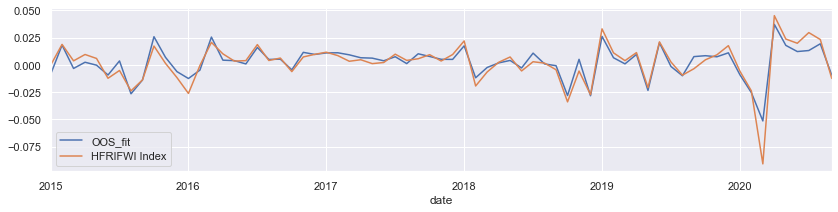

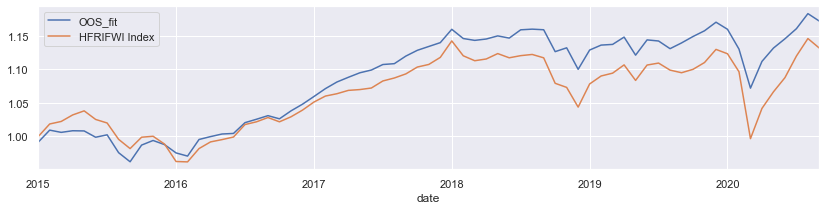

,OOS_fit,HFRIFWI Index
OOS_fit,1.0000,0.9338
HFRIFWI Index,0.9338,1.0000


In [141]:
# Out-of-Sample Performances
facs = pd_merrill_facs
date_range = facs['01-2015':'09-2020'].index
oos_fitted = pd.Series(index=date_range, name='OOS_fit')

for date in date_range:
    date_month_prior = pd.DatetimeIndex([date]).shift(periods=-1, freq='M')[0] # shifts before one unit?
    df_subset = facs[:date_month_prior]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rhs = sm.add_constant(df_subset[merrill_facs])
    lhs = df_subset['HFRIFWI Index']
    res = sm.OLS(lhs, rhs, drop="missing").fit()
    alpha = res.params['const']
    beta = res.params.drop(index='const')
    x_t = facs.loc[date, merrill_facs]
    predicted_next_value = alpha + x_t @ beta
    oos_fitted[date] = predicted_next_value

oos_fitted['01-2015':].plot(figsize=(14,3))
facs.loc['01-2015':,'HFRIFWI Index'].plot()
plt.legend()
plt.show()
None

(oos_fitted['01-2015':] + 1).cumprod().plot(figsize=(14,3))
(facs.loc['01-2015':,'HFRIFWI Index'] + 1).cumprod().plot()
plt.legend()
plt.show()
None

display((pd.DataFrame([oos_fitted, facs.loc['01-2015':,'HFRIFWI Index']])).T.corr())